In [23]:
library(scater)
library(scran)

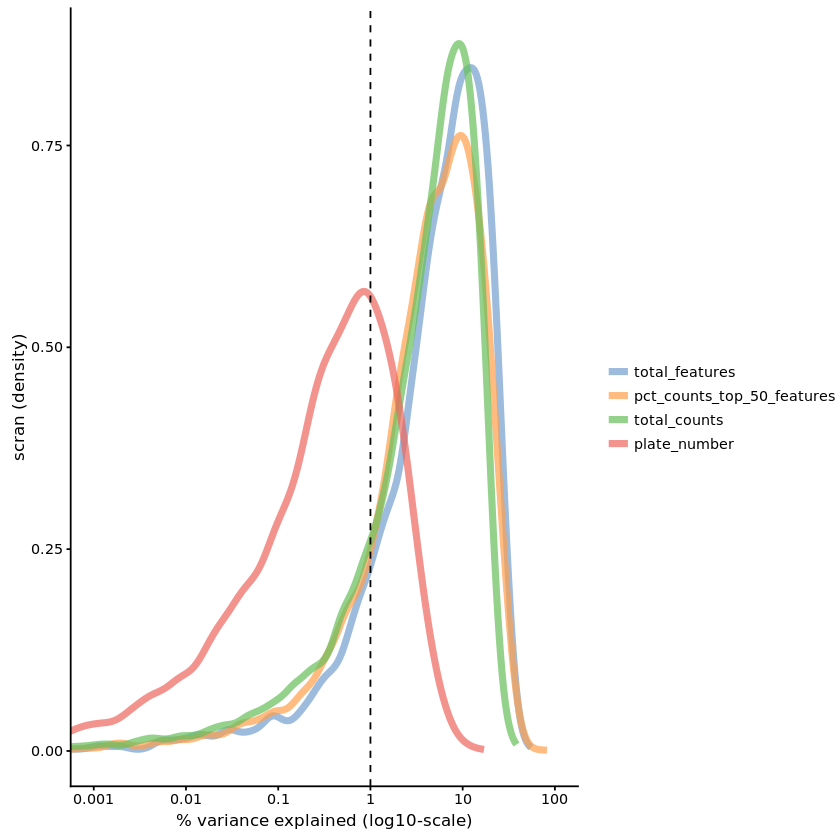

In [15]:
sce <- readRDS("completely_normalised_data.scran.rds")

# Quick check that it IS the same SCE
plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
)) + ylab(paste(sce$namer, " (density)", sep=""))

In [32]:
umi.qc <- sce
dim(umi.qc)

message("First we will apply the MNN correction which assumes that a common biological signal
exists across batches. (This will take ~ 5mins to run.)")

assay(umi.qc, "mnn") <- mnnCorrect(
    logcounts(umi.qc[,umi.qc$plate_number == "plate1"]),
    logcounts(umi.qc[,umi.qc$plate_number == "plate2"]),
    k = 20,
    sigma = 0.1,
    cos.norm.in = TRUE,
    svd.dim = 2
)

[1] 10753   192

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [33]:
message("And now we will try a GLM model")

glm_fun <- function(g, batch) {
  model <- glm(g ~ batch)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}
effects <- apply(
    logcounts(umi.qc), 
    1, 
    glm_fun, 
    batch = umi.qc$plate_number
)
corrected <- logcounts(umi.qc) - t(effects[as.numeric(factor(umi.qc$plate_number)), ])
assay(umi.qc, "glm") <- corrected

And now we will try a GLM model


In [38]:
message("Combat does the same thing, but fancier.")
library(sva)

combat_data <- logcounts(umi.qc)
mod_data <- as.data.frame(t(combat_data))
# Basic batch removal
mod0 = model.matrix(~ 1, data = mod_data) 
# adjust for total genes detected
mod2 = model.matrix(~ umi.qc$total_features, data = mod_data)
assay(umi.qc, "combat") <- ComBat(
    dat = t(mod_data), 
    batch = factor(umi.qc$plate_number), 
    mod = mod0,
    par.prior = TRUE,
    prior.plots = FALSE
)

Combat does the same thing, but fancier.
Loading required package: mgcv
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:Biostrings’:

    collapse

The following object is masked from ‘package:IRanges’:

    collapse

This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: ‘genefilter’

The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars

Found2batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



Now let us verify whether the PCA's have improved due to any of these confounder
removal methods


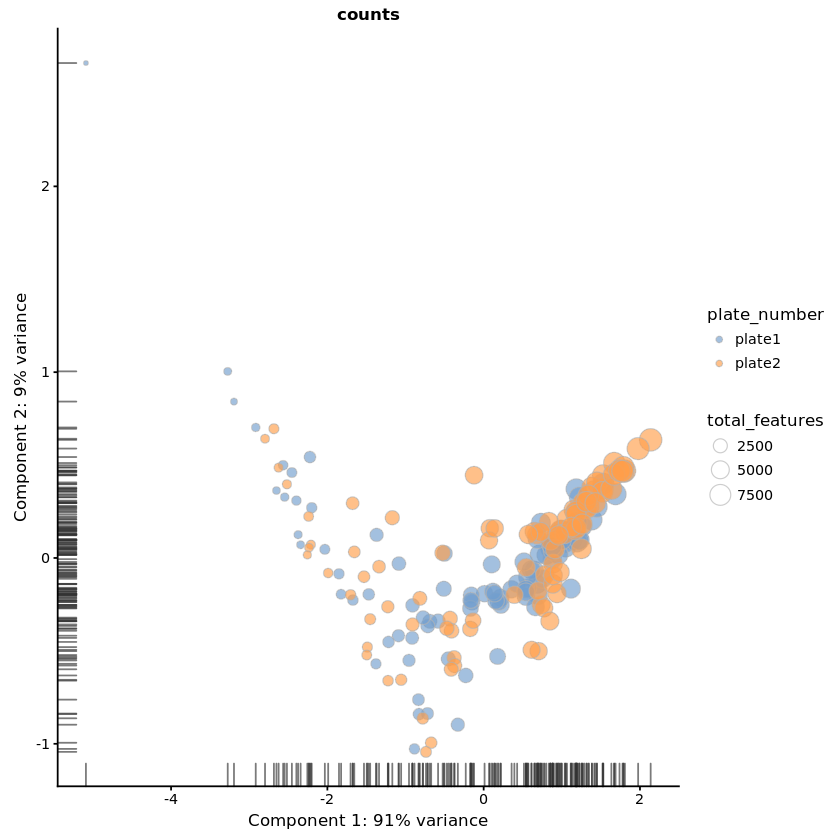

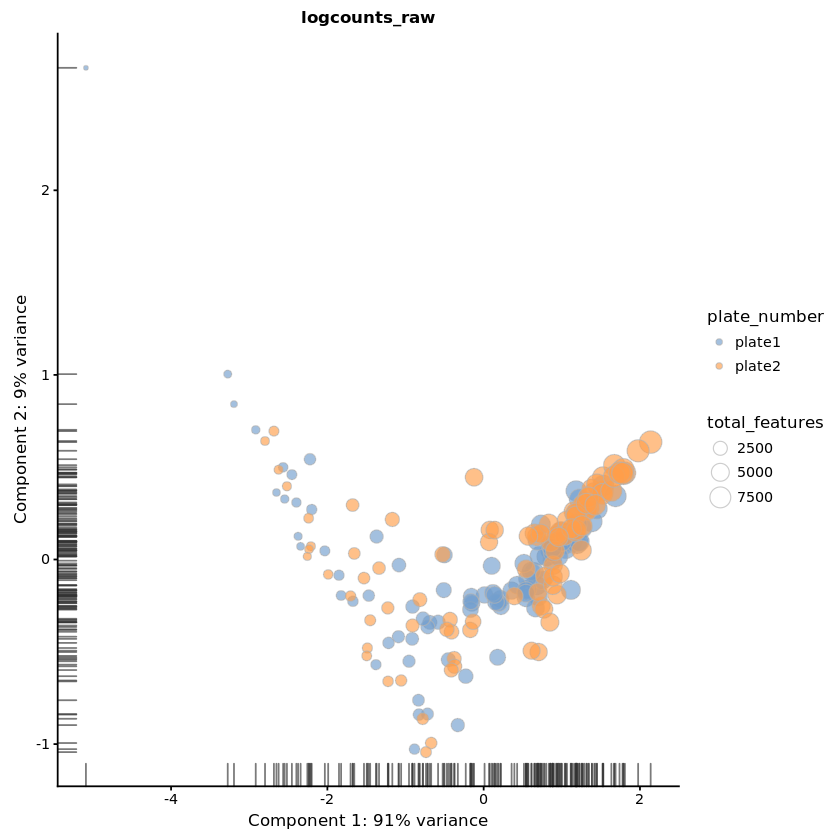

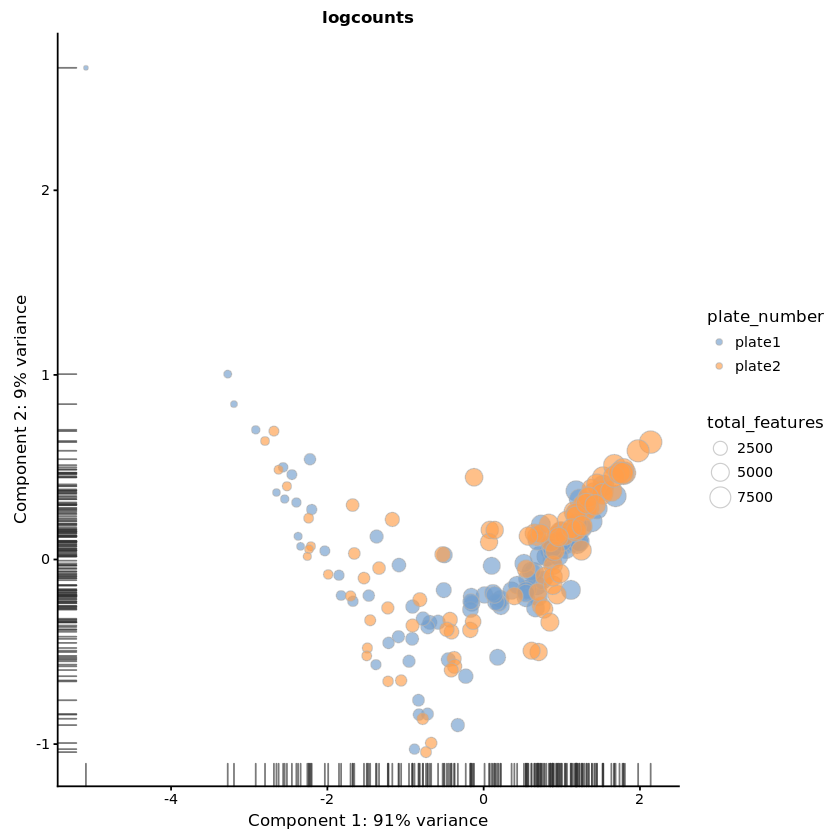

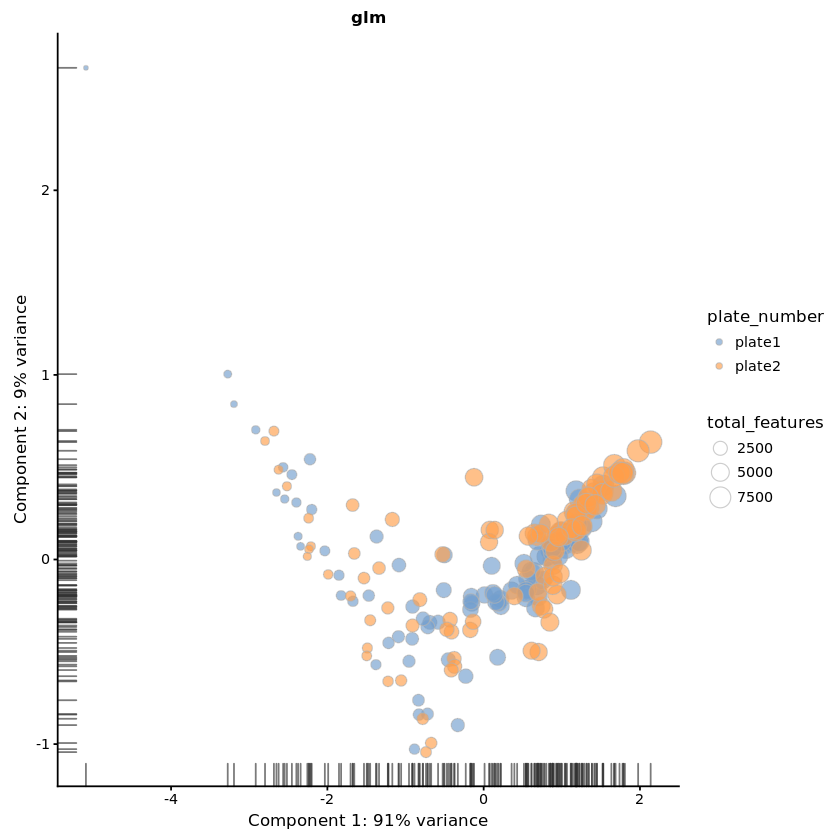

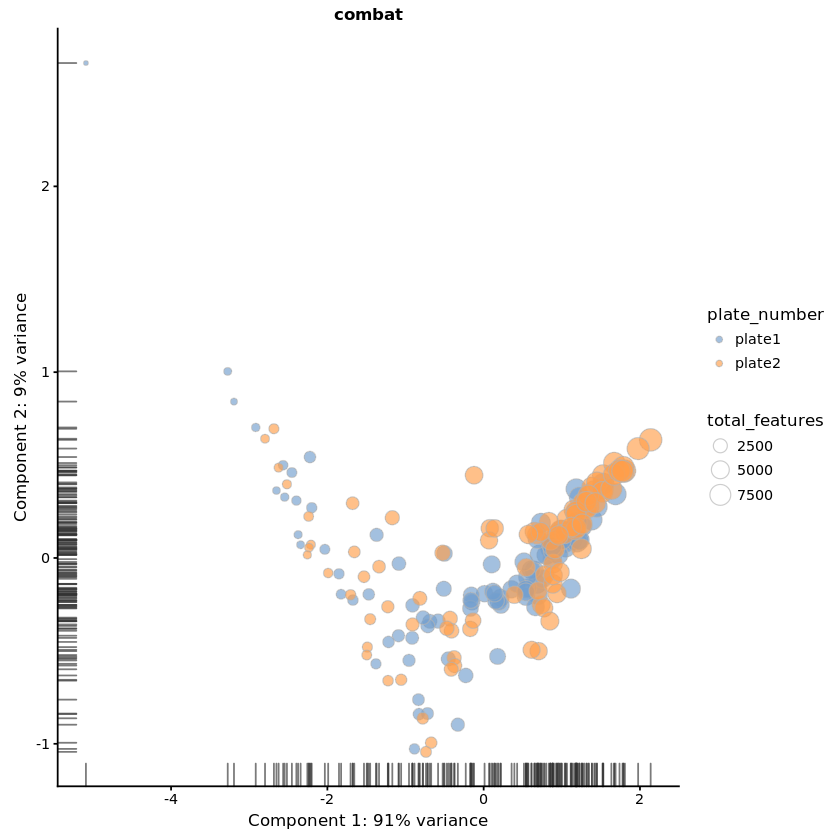

In [40]:
message("Now let us verify whether the PCA's have improved due to any of these confounder
removal methods")

for(n in assayNames(umi.qc)) {
    print(
        plotPCA(
            umi.qc,
            colour_by = "plate_number",
            size_by = "total_features",
            exprs_values = n
        ) +
        ggtitle(n)
    )
}

There appears to be no change in clustering. Either the biological signal is too 
weak to pick up on or there were never any significant technical confounding factors.


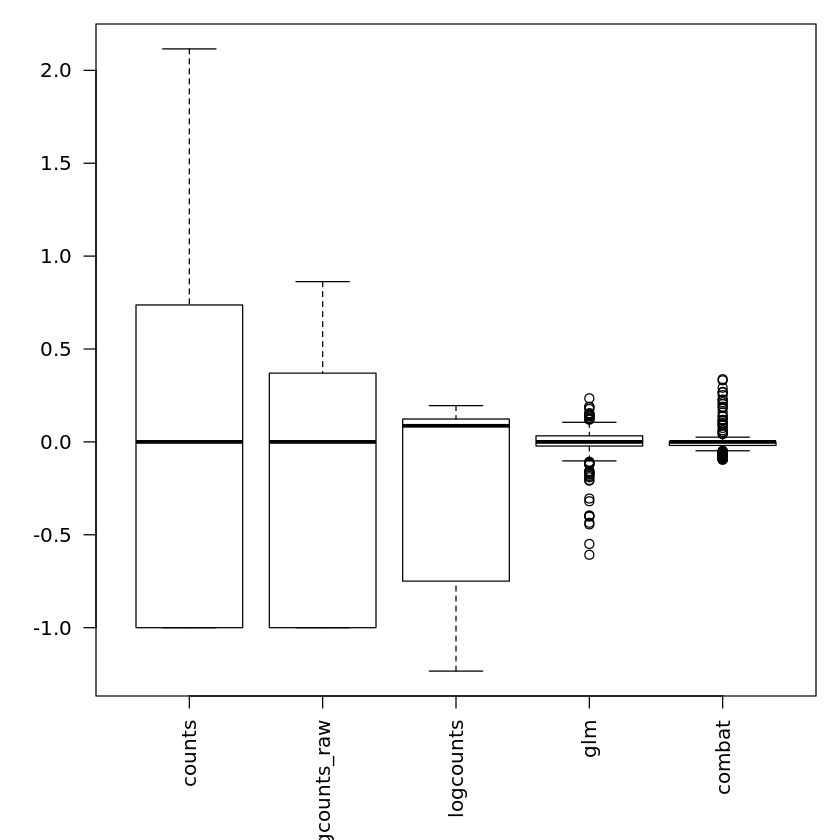

In [43]:
library(scRNA.seq.funcs)

message("There appears to be no change in clustering. Either the biological signal is too 
weak to pick up on or the confounding factors were minor technical or systematic variations.")

res <- list()
for(n in assayNames(umi.qc)) {
    res[[n]] <- suppressWarnings(calc_cell_RLE(assay(umi.qc, n)))
}
par(mar=c(6,4,1,1))
boxplot(res, las=2)

message("
We can see that glm and combat have significantly reduced the relative log expression across
cells. The variation in the average number of genes now appear to be equal for each cell, so
although we did not pick up on our biological signal, we have removed systematic variation.
")


Warning message in plotExplanatoryVariables(object, ...):
“variable batch not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable individual not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable pct_counts_ERCC not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable pct_counts_MT not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable batch not found in colData(object).
                     

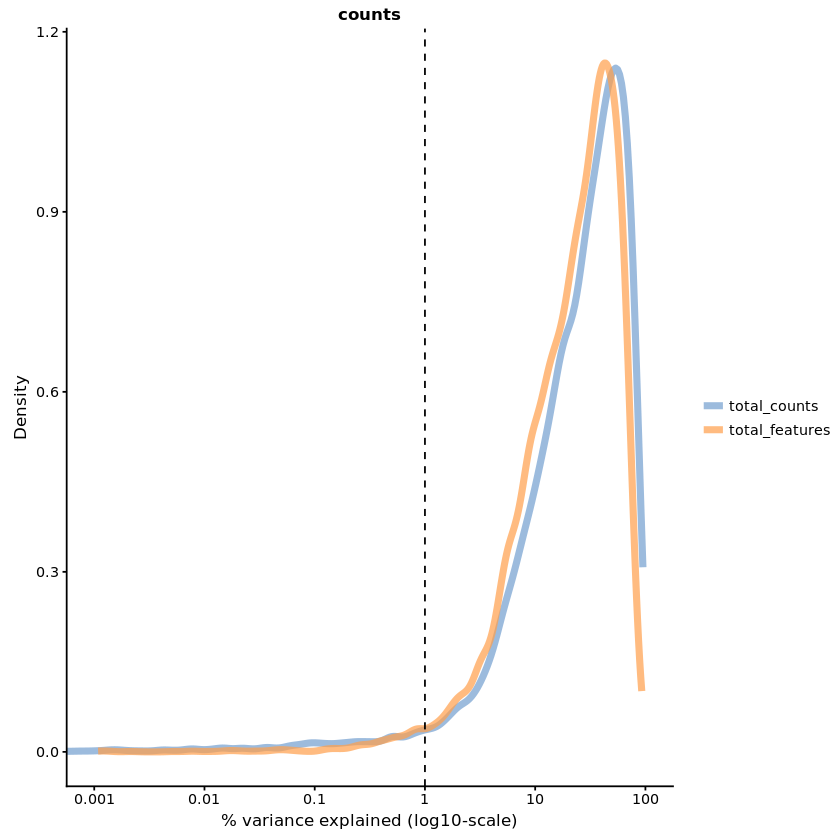

Warning message in plotExplanatoryVariables(object, ...):
“variable batch not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable individual not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable pct_counts_ERCC not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable pct_counts_MT not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”

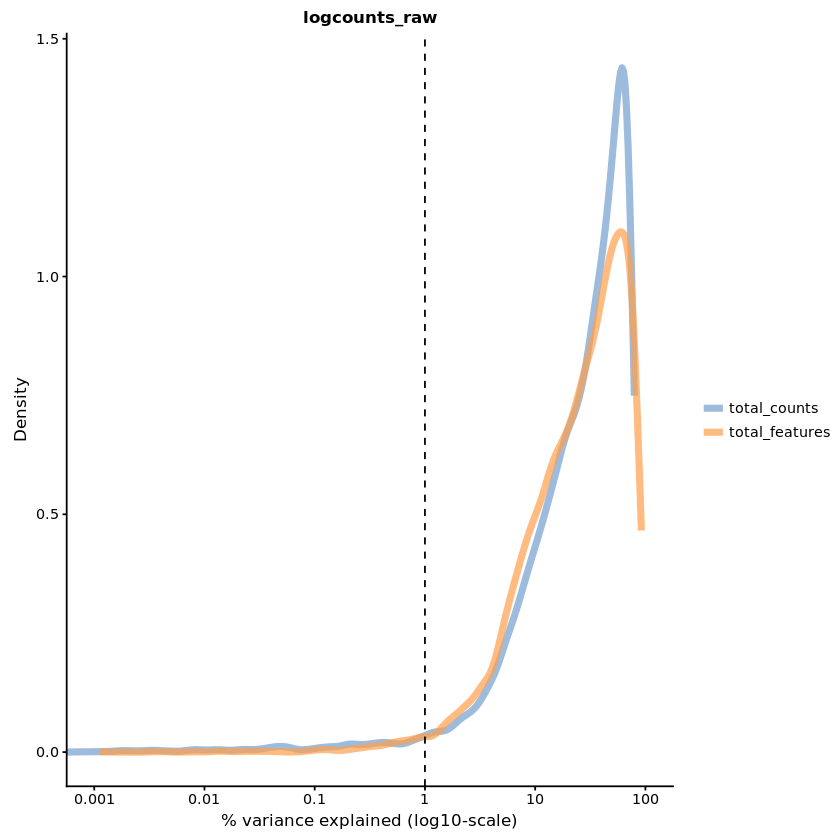

Warning message in plotExplanatoryVariables(object, ...):
“variable batch not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable individual not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable pct_counts_ERCC not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”Warning message in plotExplanatoryVariables(object, ...):
“variable pct_counts_MT not found in colData(object).
                     Please make sure colData(object)[, variable] exists. This variable will not be plotted.”

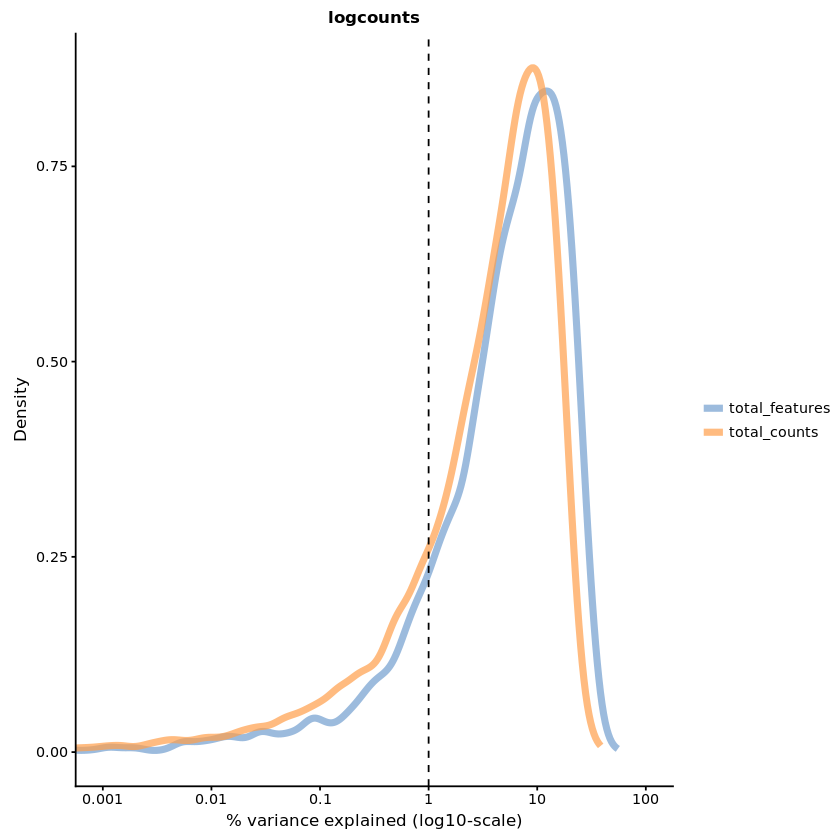

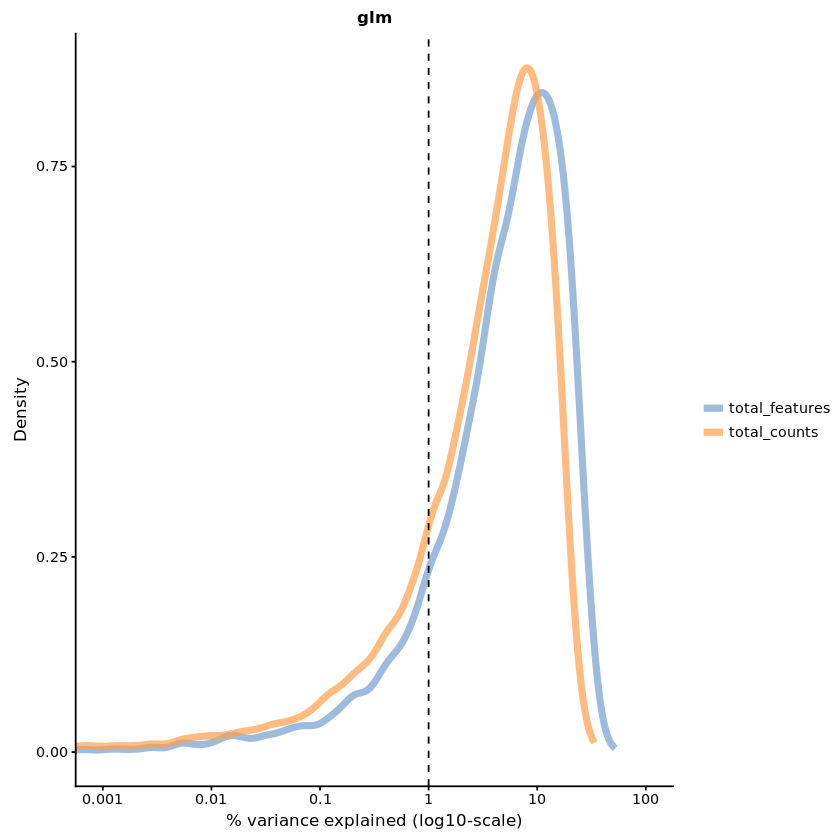

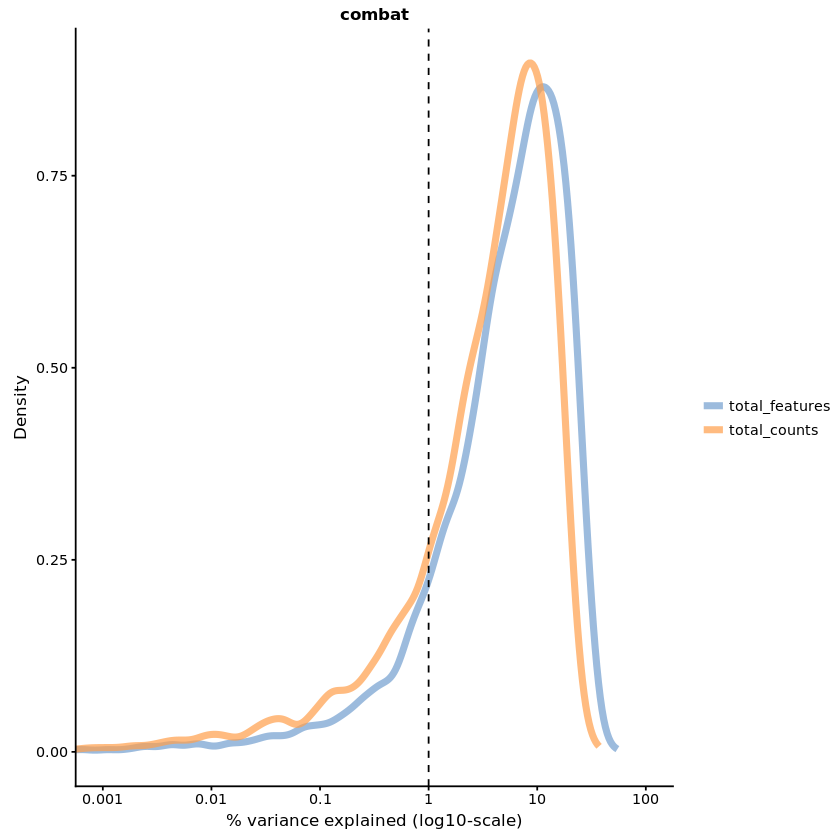

In [45]:
for(n in assayNames(umi.qc)) {
    print(
        plotQC(
            umi.qc,
            type = "expl",
            exprs_values = n,
            variables = c(
                "total_features",
                "total_counts",
                "batch",
                "individual",
                "pct_counts_ERCC",
                "pct_counts_MT"
            )
        ) +
        ggtitle(n)
    )
}

message("
We can see again the GLM and Combat both reduced (slightly) the variation contributed by
the read-depth and library-size.")

In [60]:
# Save our changes and move to the next section
message("We will pick combat as our most effective de-confounding tool.")
saveRDS(umi.qc, "completely_normalised_data.scran.combat_glm.rds")

We will pick combat as our most effective de-confounding tool.
